In [1]:
import numpy as np


class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta #학습률 (0.0과 1.0 사이)
        self.n_iter = n_iter #에포크 횟수
        self.random_state = random_state

    def fit(self, X, y):
        #가중치를 초기화한 후 훈련 데이터셋을 반복 순회하여 가중치를 업데이트함
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        #self.w_ : 가중치
        #rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) : 표준편차가 0.01인 정규분포에서 뽑은 랜덤한 작은 수
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors) #잘못 분류된 횟수 기록
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0] #wTx 계산

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1) #클래스 레이블 예측

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)

df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail()

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


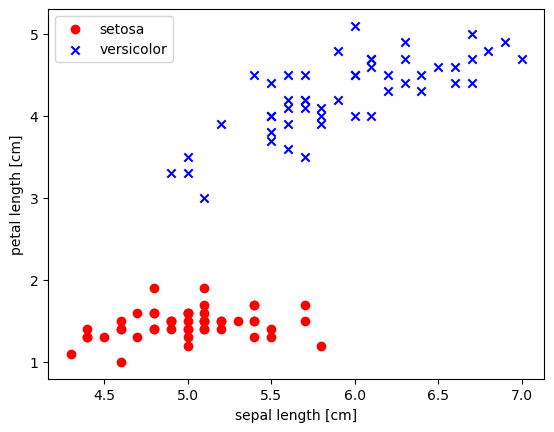

In [5]:
%matplotlib inline


# setosa와 versicolor를 선택합니다
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# 꽃받침 길이와 꽃잎 길이를 추출합니다
X = df.iloc[0:100, [0, 2]].values

# 산점도를 그립니다, setosa-음성, versicolor-양성
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.show()

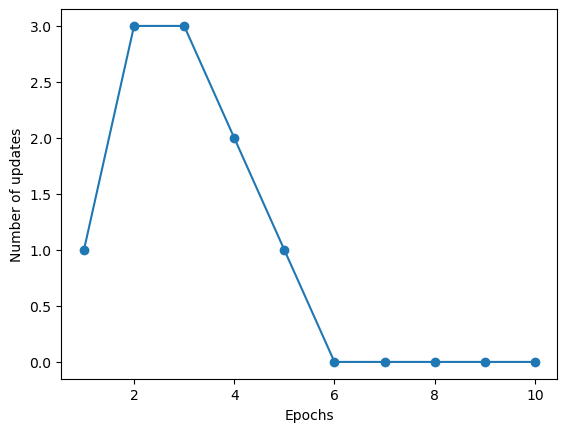

In [7]:
#퍼셉트론 모델 훈련하기
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.show()

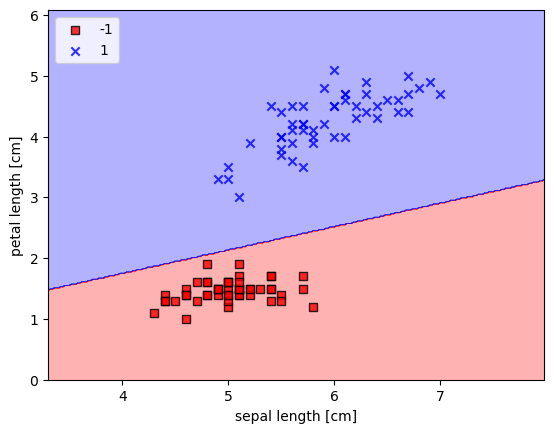

In [8]:
#결정 경계 그래프 함수
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # 꽃받침 길이 최소/최대
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # 꽃잎 길이 최소/최대
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), #grid 배열
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor=None if idx==1 else 'black')

plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

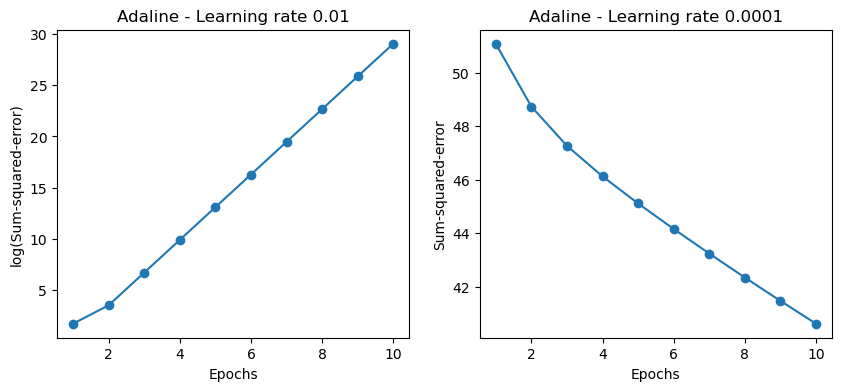

In [9]:
class AdalineGD(object):
    """적응형 선형 뉴런 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : array-like, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # 이 코드의 활성화 함수는 항등 함수(identity function)이기 때문에
            # 아무런 효과가 없습니다.
            # 이 대신 `output = self.net_input(X)`로 바로 쓸 수 있습니다.
            # 이 활성화 함수는 개념적인 목적을 위해 만들었습니다.
            # (잠시 후에 보게 될) 로지스틱 회귀의 경우 이 함수를 시그모이드 함수로
            # 바꾸어 로지스틱 회귀 분류기를 구현합니다.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()


In [10]:
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        #가중치를 다시 초기화하지 않고 훈련 데이터를 학습
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        #훈련 데이터를 섞기
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        #반복적인 순환이 일어나지 않도록 매 에포크가 일어나기 전, 훈련 샘플을 섞음
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        #아달린 학습 규칙을 적용하여 가중치를 업데이트
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        #단위 계단 함수를 사용하여 클래스 레이블을 반환
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
        
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/02_15_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()

NameError: name 'X_std' is not defined

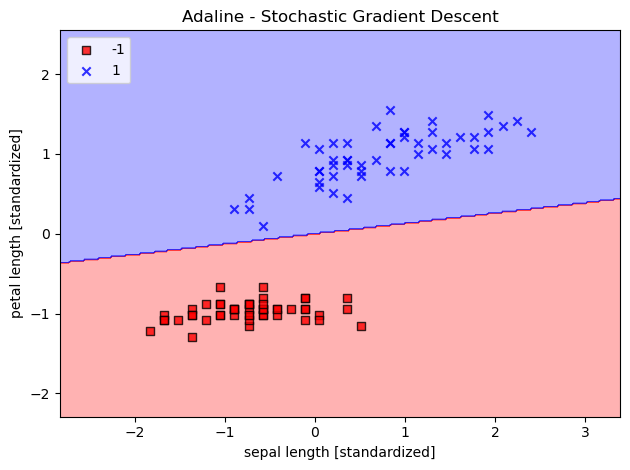

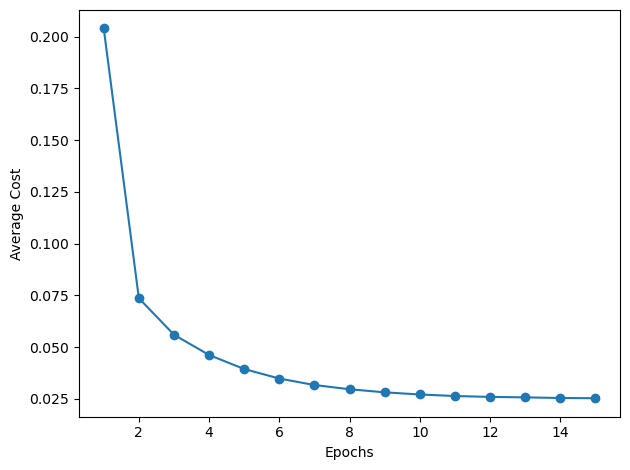

In [12]:
# 특성을 표준화합니다.
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
class AdalineSGD(object):
    """ADAptive LInear NEuron 분류기

    Parameters
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    shuffle : bool (default: True)
      True로 설정하면 같은 반복이 되지 않도록 에포크마다 훈련 데이터를 섞습니다
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    Attributes
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      모든 훈련 샘플에 대해 에포크마다 누적된 평균 비용 함수의 제곱합

    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃 벡터

        반환값
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """가중치를 다시 초기화하지 않고 훈련 데이터를 학습합니다"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """훈련 데이터를 섞습니다"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """랜덤한 작은 수로 가중치를 초기화합니다"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """아달린 학습 규칙을 적용하여 가중치를 업데이트합니다"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost

    def net_input(self, X):
        """입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """선형 활성화 계산"""
        return X

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/02_15_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
# plt.savefig('images/02_15_2.png', dpi=300)
plt.show()
